In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from sklearn.cluster import KMeans
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering

from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_decision_forests as tfdf

from sklearn.datasets import make_classification

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [25]:
path = './traces_core'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/dpotrf_T-200_C-2-*.prof*")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    trace.close()
    
    li.append(data)
    print(filename)

df = pd.concat(li, axis=0, ignore_index=True)


./traces_core/dpotrf_T-200_C-2-0.prof.h5
./traces_core/dpotrf_T-200_C-2-1.prof.h5


In [26]:
print(len(li))

2


# Clean the data

In [27]:
df = df[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df['exec_time'] = (df['end'] - df['begin']) * .001 #0.001 nano seconds to micro seconds
df = df.astype(float)

In [28]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}

In [29]:

filter = ( (df['task_class_id'] >= 0 ) & ( df['task_class_id'] <= 3 ) & ( df['priority'] >= 0 ) )
#remove all other classes other than dpotrf, dgemm, trsm and syrk
df = df[filter]
df.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
29701,1172113.0,1842689.0,2.0,2.0,0.0,1.0,320000.0,0.0,670.576
29702,1849417.0,2517115.0,2.0,2.0,0.0,1.0,320000.0,0.0,667.698
29703,2523088.0,2799015.0,2.0,1.0,0.0,2.0,320000.0,0.0,275.927
29704,2804805.0,3481094.0,2.0,2.0,0.0,1.0,320000.0,0.0,676.289
29705,3485968.0,4154086.0,2.0,2.0,0.0,1.0,320000.0,0.0,668.118


## integrate likelihood of the data being in cash.
we assume that all the task whose execution time is in the first quartile could have had all its data in the cache. While, the rest of the tasks would have resulted in a cache flush. While predicting we assume that the that the data of the task is not in the cache 

In [30]:
df[df['task_class_id'] == 3].head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
30843,1.537896e+09,1.538457e+09,4.0,3.0,0.0,3.0,960000.0,885906.0,560.433
30844,1.538476e+09,1.539034e+09,4.0,3.0,0.0,3.0,960000.0,859115.0,557.978
30848,1.540480e+09,1.541043e+09,4.0,3.0,0.0,3.0,960000.0,831742.0,562.529
30849,1.541066e+09,1.541589e+09,4.0,3.0,0.0,3.0,960000.0,885900.0,523.493
30852,1.542614e+09,1.543150e+09,4.0,3.0,0.0,3.0,960000.0,857963.0,535.999


In [31]:
df.reset_index(inplace=True)

----------------- dpotrf [before] -------------------------- 
Min = 262.269
Max = 18301.32
Avg = 759.2395166666662
Std = 2310.226292288391
----------------- dpotrf [after] -------------------------- 
Min = 286.009
Max = 317.475
Avg = 301.15867355371915
Std = 5.586661768405834
datapoints removed 19.333333333333332%
----------------- dtrsm [before] -------------------------- 
Min = 238.25400000000002
Max = 117092.44
Avg = 961.2495648821636
Std = 2608.6713047755725
----------------- dtrsm [after] -------------------------- 
Min = 238.25400000000002
Max = 940.649
Avg = 441.56193201133067
Std = 146.19659725486142
datapoints removed 4.915824915824916%
----------------- dsyrk [before] -------------------------- 
Min = 169.716
Max = 158949.491
Avg = 958.3838502970322
Std = 3309.4389921567035
----------------- dsyrk [after] -------------------------- 
Min = 353.38800000000003
Max = 484.153
Avg = 417.9848646209403
Std = 24.315337896859656
datapoints removed 12.237623762376238%
----------------- 

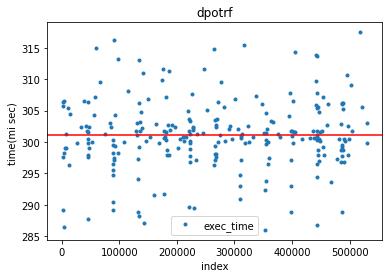

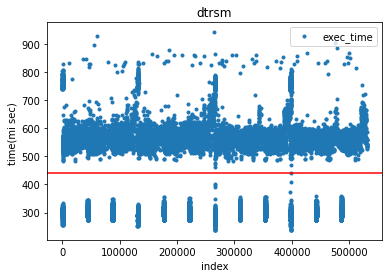

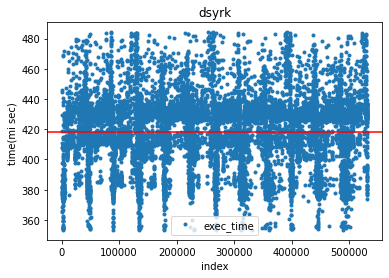

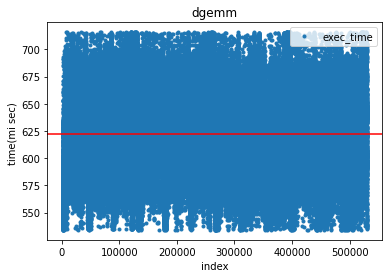

In [32]:
task_class_id = [0,1,2,3]

for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    
    print('----------------- ' + df_class_name[i] + ' [before] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))
    datapoint1 = df_refined.shape[0]
    
    Q1 = df_refined['exec_time'].quantile(0.25)
    Q3 = df_refined['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_refined['exec_time'] >= Q1 - 1.5 * IQR) & (df_refined['exec_time'] <= Q3 + 1.5 *IQR)
    df_refined = df_refined.loc[filter]
    df_refined = df_refined.astype(float)
    
    print('----------------- ' + df_class_name[i] + ' [after] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))
    datapoint2 = df_refined.shape[0]
    
    perc_of_data = (datapoint1 - datapoint2) / datapoint1 * 100
    print('datapoints removed ' + str(perc_of_data) + '%')
    
    ax = df_refined.plot(y='exec_time',  use_index=True,
                    ylabel='time(mi sec) ', xlabel='index',
                    marker='.', linestyle='none',
                    title=df_class_name[i])
    ax.axhline(sum(df_refined['exec_time']) / len(df_refined['exec_time']), c='r')
    plt.savefig(df_class_name[i]+'_cloud', dpi=300)
    
    

## K-means

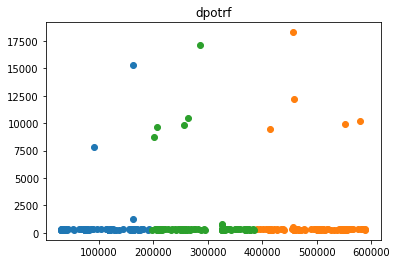

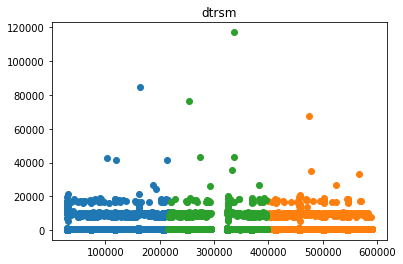

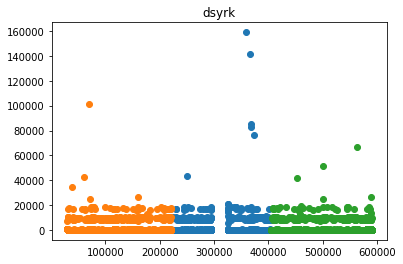

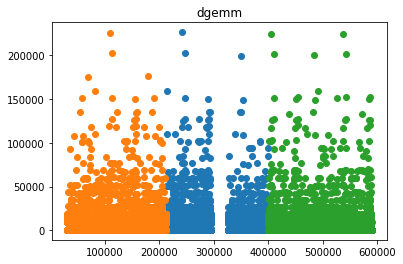

In [33]:
task_class_id = [0,1,2,3]

for i in task_class_id:
    # define dataset
    df_exaxmple = df
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    x = df_refined[['index', 'exec_time']].copy()
    X = x.to_numpy()
    # define the model
    model = KMeans(n_clusters=3)
    # fit the model
    model.fit(X)
    # assign a cluster to each example
    yhat = model.predict(X)
    # retrieve unique clusters
    clusters = unique(yhat)
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
        pyplot.title(df_class_name[i])
    # show the plot
    pyplot.show()

## Reorder

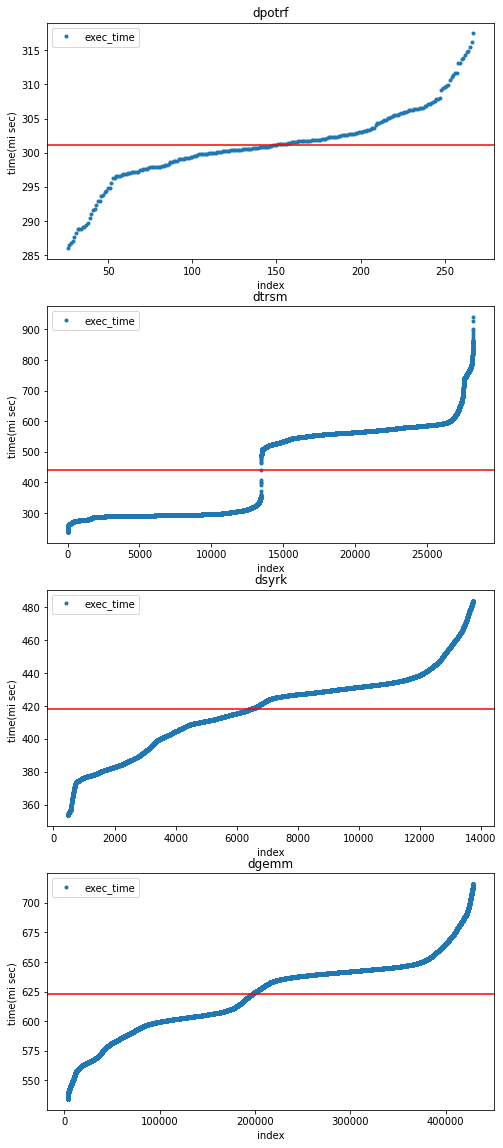

In [35]:
task_class_id = [0,1,2,3]
fig, axs = plt.subplots(4)
for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    df_refined = df_refined.sort_values('exec_time', axis=0, ascending=True, 
                                        inplace=False, kind='quicksort', na_position='last')
    df_refined.insert(0, 'new_index', range(0, len(df_refined)))
    
    #print(df_refined.head())
    
    
    Q1 = df_refined['exec_time'].quantile(0.25)
    Q3 = df_refined['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_refined['exec_time'] >= Q1 - 1.5 * IQR) & (df_refined['exec_time'] <= Q3 + 1.5 *IQR)
    df_refined = df_refined.loc[filter]
    df_refined = df_refined.astype(float)
    
    
    
    ax = df_refined.plot(y='exec_time',  x='new_index',
                    ylabel='time(mi sec) ', xlabel='index',
                    marker='.', linestyle='none',
                    title=df_class_name[i], ax=axs[i], figsize=(8, 20))
    
    
    ax.axhline(sum(df_refined['exec_time']) / len(df_refined['exec_time']), c='r')
    #plt.savefig(df_class_name[i]+'_reorder', dpi=300)
plt.savefig('reorder_core 2', dpi=300)    
    
    

